In [273]:
%reset -f

In [2]:
import pandas as pd
import numpy as np
from ipywidgets import AppLayout, Button, GridspecLayout, Image, Layout, Text, Box
import random
from sklearn import preprocessing
import sklearn
from sklearn.model_selection import train_test_split
import random
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [3]:
readers = pd.read_csv('vgsales.csv')           #on importe notre base de données
copy = readers                                 #on effectue un copie de la base de données avant pré-processing

# Explication du projet

Nous avons trouvé notre base de données su kaggle à l'adresse suivante : https://www.kaggle.com/kedokedokedo/vgsales

Notre base de données contient des informations sur chaque jeu ainsi que ses ventes. 

Le but de notre projet sera de conseiller des acheteurs selon leurs préférences de jeux vidéos. Nos labels seront donc une colonne 'Interested' que nous allons créer. Notre base de données n'est donc pas labelisé et nous allons donc essayer de simuler dans ce projet les préférences d'un acheteur. 

Nous allons essayer de labeliser nos données de manières différentes.

A la fin du projet, l'objectif est de faire une application en direct et appliquer le meilleur modèle trouvé aux étapes précédentes à chaque fois qu'un jeu vidéo est labelisé.


Voici le plan de notre projet : 


I. Pré-processing


II. Labelisation "à la main"
   1. labelisation binaire
   2. préférences
   
   
III. Application du modèle
   1. modèle binaire
   2. modèle avec préférences
    

## I.Pré-traitement
Dans cette partie nous allons pre-traiter nos données.


Nos données sont à l'état brut comme ceci: 

In [7]:
readers

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,259,Asteroids,2600,1980,Shooter,Atari,4.00,0.26,0.00,0.05,4.31
1,545,Missile Command,2600,1980,Shooter,Atari,2.56,0.17,0.00,0.03,2.76
2,1768,Kaboom!,2600,1980,Misc,Activision,1.07,0.07,0.00,0.01,1.15
3,1971,Defender,2600,1980,Misc,Atari,0.99,0.05,0.00,0.01,1.05
4,2671,Boxing,2600,1980,Fighting,Activision,0.72,0.04,0.00,0.01,0.77
...,...,...,...,...,...,...,...,...,...,...,...
16319,16565,Mighty No. 9,XOne,2016,Platform,Deep Silver,0.01,0.00,0.00,0.00,0.01
16320,16572,Resident Evil 4 HD,XOne,2016,Shooter,Capcom,0.01,0.00,0.00,0.00,0.01
16321,16573,Farming 2017 - The Simulation,PS4,2016,Simulation,UIG Entertainment,0.00,0.01,0.00,0.00,0.01
16322,16579,Rugby Challenge 3,XOne,2016,Sports,Alternative Software,0.00,0.01,0.00,0.00,0.01


Nous mélangeons ensuite notre base de données initiale au ca où elles sont triées.

In [8]:
readers = sklearn.utils.shuffle(readers)

On regarde ensuite les informations sur notre base de données pour voir si elle est complète.

In [9]:
readers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16324 entries, 1240 to 7579
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16324 non-null  int64  
 1   Name          16324 non-null  object 
 2   Platform      16324 non-null  object 
 3   Year          16324 non-null  int64  
 4   Genre         16324 non-null  object 
 5   Publisher     16288 non-null  object 
 6   NA_Sales      16324 non-null  float64
 7   EU_Sales      16324 non-null  float64
 8   JP_Sales      16324 non-null  float64
 9   Other_Sales   16324 non-null  float64
 10  Global_Sales  16324 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB


Les données de publisher cont incomplètes, il nous en manque peu et notre base de données est assez grande pour qu'on puisse les retirer.

In [10]:
readers=readers.dropna(subset = ["Publisher"])

Nous allons vérifier que nos informations sur les genre sont équilibrées.

In [11]:
readers.Genre.value_counts()

Action          3250
Sports          2304
Misc            1686
Role-Playing    1468
Shooter         1282
Adventure       1274
Racing          1225
Platform         875
Simulation       848
Fighting         836
Strategy         670
Puzzle           570
Name: Genre, dtype: int64

Les données sur le genre sont plutôt équilibrées, nous allons à présent regarder les informations que nous avons sur la feature "platform" pour voir si elle est équilibrée.

In [12]:
readers.Platform.value_counts()

DS      2131
PS2     2127
PS3     1304
Wii     1290
X360    1234
PSP     1197
PS      1189
PC       938
XB       803
GBA      786
GC       542
3DS      499
PSV      408
PS4      335
N64      316
SNES     239
XOne     213
SAT      173
WiiU     143
2600     116
NES       98
GB        97
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
PCFX       1
GG         1
Name: Platform, dtype: int64

Nous remarquons qu'il y a des plateformes avec peu de jeux. Nous allons donc supprimer toutes les consoles qui ont moins de 100 jeux.

In [13]:
indesirable = ['SAT','2600','NES','GB', 'DC', 'GEN', 'NG', 'SCD', 'WS', '3DO', 'TG16', 'GG', 'PCFX','PSV']
for elt in indesirable:
    readers = readers.drop(readers[readers.Platform == elt].index)

In [14]:
readers.Platform.value_counts()

DS      2131
PS2     2127
PS3     1304
Wii     1290
X360    1234
PSP     1197
PS      1189
PC       938
XB       803
GBA      786
GC       542
3DS      499
PS4      335
N64      316
SNES     239
XOne     213
WiiU     143
Name: Platform, dtype: int64

Nous allons ensuite regrouper les plateformes par marque plutôt que par console.

In [15]:
readers['Platform'] = readers['Platform'].replace(['DS','Wii','GBA','GC','3DS','N64','SNES','WiiU'], 'Nintendo')
readers['Platform'] = readers['Platform'].replace(['PS2','PS3','PSP','PS','PS4'], 'Sony')
readers['Platform'] = readers['Platform'].replace(['X360','XB','XOne'], 'Microsoft')

In [16]:
readers.Platform.value_counts()

Sony         6152
Nintendo     5946
Microsoft    2250
PC            938
Name: Platform, dtype: int64

On va laisser les colonnes "rank" et "other_sales" car elles ne sont pas pertinentes pour notre analyse.

In [17]:
readers = readers.drop(columns=["Rank","Other_Sales"])

In [18]:
readers

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Global_Sales
1240,Syndicate Wars,Sony,1997,Strategy,Electronic Arts,0.02,0.01,0.00,0.04
4400,Dinotopia: The Sunstone Odyssey,Microsoft,2003,Action,TDK Mediactive,0.01,0.00,0.00,0.01
9918,Puzzler World,Nintendo,2009,Puzzle,Ubisoft,0.41,0.30,0.00,0.78
11915,Zangeki no Reginleiv,Nintendo,2010,Action,Nintendo,0.00,0.00,0.11,0.11
6143,Super Monkey Ball: Banana Blitz,Nintendo,2006,Misc,Sega,1.07,0.92,0.04,2.27
...,...,...,...,...,...,...,...,...,...
3481,Bust-A-Bloc,Sony,2002,Puzzle,Midas Interactive Entertainment,0.00,0.00,0.05,0.05
11728,Mathews Bowhunting,Nintendo,2010,Sports,Zoo Games,0.18,0.00,0.00,0.19
12604,Need for Speed: Shift 2 Unleashed,Sony,2011,Racing,Electronic Arts,0.20,0.36,0.00,0.69
2445,NASCAR Heat 2002,Sony,2001,Racing,Infogrames,0.29,0.23,0.00,0.60


On va afficher les ventes et chercher d'éventuelles valeurs aberrantes

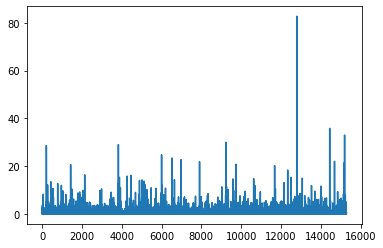

In [19]:
abs = np.linspace(0, readers.shape[0], readers.shape[0])
y = readers['Global_Sales'].values.tolist()

plt.plot(abs, y)

On se rend compte qu'il y a un outlier on va chercher et supprimer la donnée.

In [20]:
maxsales = readers.max()['Global_Sales']
readers=readers.drop(readers[readers.Global_Sales==maxsales].index)

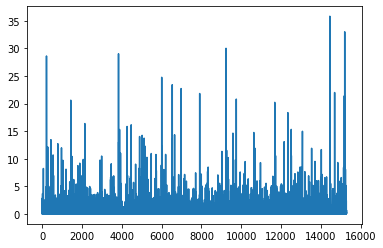

In [21]:
abs = np.linspace(0, readers.shape[0], readers.shape[0])
y = readers['Global_Sales'].values.tolist()

plt.plot(abs, y)

La valeur aberrante a bien été supprimée, nous allons regarder les ventes en Amérique du Nord, en Europe et au Japon

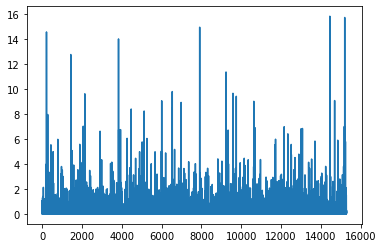

In [22]:
abs = np.linspace(0, readers.shape[0], readers.shape[0])
y = readers['NA_Sales'].values.tolist()

plt.plot(abs, y)

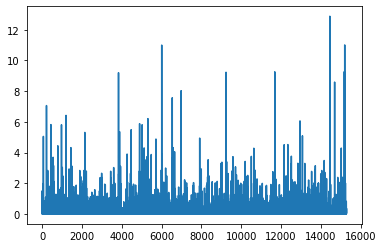

In [23]:
abs = np.linspace(0, readers.shape[0], readers.shape[0])
y = readers['EU_Sales'].values.tolist()

plt.plot(abs, y)

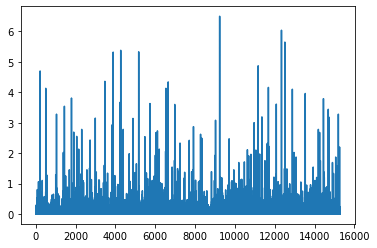

In [24]:
abs = np.linspace(0, readers.shape[0], readers.shape[0])
y = readers['JP_Sales'].values.tolist()

plt.plot(abs, y)

Les ventes au Japon, Europe et Amérique du Nord ont l'air cohérentes, nous n'avons pas de valeurs aberrantes à supprimer.

Nous ajoutons une colonne "interest" qui montrera l'intérêt ou non de notre utilisateur sur ce jeu vidéo. Nous initialisions cette colonne à "None"

In [25]:
readers["Interest"] = None

Nous allons ensuite encoder notre base de données. 

In [26]:
cols = ["Platform", "Genre","Publisher","Name"]
enc = preprocessing.OrdinalEncoder()
for col in cols:
    readers[col] = enc.fit_transform(readers[[col]])
    

#L'encodage donne des florat nous allons la transformer en int pour éviter des erreurs lors de l'application des modèles.
cols=['Platform','Genre','Publisher','Name']                 

for col in cols:
    readers[cols]=readers[cols].astype(int)
    

Nous avons fini le pre-processing. Nous allons ensuite réfléchir à la manière dont nous allons labéliser "à la main" notre base de données.

## I. Labélisation "à  la main"

Nous allons créer un bot dont le but sera de simuler un acheteur afin de labéliser notre base de données. Ce bot représentera donc un acheteur qui possède une console et aime deux genres de jeux vidéos. 

On va donc choisir aléatoirement une console et un genre. 

Pour cela, nous allons regarder le nombre de genres et en choisir 2 au hasard et de la même manière choisir une console au hasard.


On choisit aussi la région de l'acheteur :


0. North America
1. Europe
2. Japon

C'est une simulation d'un acheteur que nous allons garder dans l'ensemble de la première partie du projet.

In [27]:
nbGenre=len(readers.Genre.value_counts())                            #Nombre de genre différents
nbConsole=len(readers.Platform.value_counts())                       #Nombre de plateformes différentes

In [28]:
def select(nbGenre,nbConsole):
    genreAleat1=random.randint(0,nbGenre)                      #On choisit deux genres aléatoirement
    genreAleat2=random.randint(0,nbGenre)
    consoleAleat=random.randint(0,nbConsole)                   #On choisit une console aléatoirement
    
    
    while genreAleat2==genreAleat1:                            #On fait une boucle jusqu'à ce que les deux genres soient différents
         genreAleat2=random.randint(0,nbGenre)  
            
    regionaleat=random.randint(0,2)                            #On choisit une région au hasard entre l'Amérique du Nord (NA), Europe et Japon
    
    return(genreAleat1,genreAleat2,consoleAleat,regionaleat)


bot=select(nbGenre,nbConsole)

print("Notre bot aime les genres",bot[0],"et",bot[1],"possède la plateforme",bot[3], "et habite dans la région",bot[3])



Notre bot aime les genres 11 et 2 possède la plateforme 1 et habite dans la région 1


### II. 1) Méthode binaire

Dans cette première méthode, on suppose que l'acheteur aime les jeux lorsqu'il correspond au couple (console, genre1) ou (console, genre2).

Cependant, nous allons essayer de se rapprocher de la réalité, c'est-à-dire que parfois nous faisons des choix irrationnels, c'est pour cela que nous allons labeliser notre base de données à 1 (intéressé) seulement 90% du temps. 

On ne tiendra pas compte de la région de l'acheteur dans cette première partie.

In [29]:
##On itère sur chaque ligne de la base de données
# Le for peut être un peu long car on labelise "à la main" notre base de données

def labelisation():
    proba=random.randint(1,10)

    for elt in readers.iterrows():                                   
    
    ##On regarde si le jeu correspond au couple de préférence (console, genre1) ou (console, genre2)
    
        if (((readers.loc[elt[0]].Platform==bot[2]) & (readers.loc[elt[0]].Genre==bot[0])) | ((readers.loc[elt[0]].Platform==bot[2]) & ( readers.loc[elt[0]].Genre==bot[1]))):
            if proba>1:
                readers.loc[elt[0], 'Interest'] = 1                   ##Si oui on passe le jeu à 1 dans Interest
            else :
                readers.loc[elt[0], 'Interest'] = 0
        else :
            readers.loc[elt[0], 'Interest'] = 0                 ##Si non on passe le jeu à 0 dans Interest
        
        
#On vérifie qu'il existe bien des jeux associés aux préférences dans notre base de données, autrement on retire un nouveau bot        
while len(readers.Interest.value_counts())!=2:
    bot=select(nbGenre,nbConsole)
    labelisation()

Notre base de données est maintenant encodée et labelisée, on peut sépare donc nos données en train et test

In [30]:
X = readers.drop('Interest',axis=1)
y = readers['Interest']
y=y.astype('int')


X_train, X_test,y_train,y_test= train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train)
print(y_train)


        Name  Platform  Year  Genre  Publisher  NA_Sales  EU_Sales  JP_Sales  \
5509    6518         1  2005      5        316      0.16      0.00      0.10   
15798   5571         0  2015      0        263      0.00      0.04      0.00   
8353    8417         0  2008      0        265      1.74      0.80      0.00   
10783   8732         1  2009      1        240      0.00      0.00      0.07   
16134  10540         1  2016      1         26      0.04      0.00      0.01   
...      ...       ...   ...    ...        ...       ...       ...       ...   
15761   5632         2  2015      2        503      0.01      0.04      0.00   
15455   6283         1  2015      3        328      0.01      0.61      0.02   
12789   7482         0  2011     10          5      0.03      0.21      0.00   
10693   4941         1  2009     10        454      0.08      0.00      0.00   
8479    8183         3  2008      4        409      0.56      0.33      0.01   

       Global_Sales  
5509           0.

Nous allons ensuite appliquer les différents modèles à l'aide d'une validation croisée sur 3 jeux de données. On affichera les résultats à la fin.

### Application des modèles

Nos données sont discrètes, on va donc utiliser les modèles qui marchent pour ce type de données à savoir : la logistic regression, knn, random forest, adaboost et xgboost.

#### Logistic Regression

In [31]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)


scores_logmodel = cross_validate(logmodel, X_train, y_train, cv=3, scoring=('accuracy','precision','recall','roc_auc') )

print("Le score moyen est :" + str(scores_logmodel['test_accuracy'].mean()))
print("La vitesse moyenne fit_time : " + str(scores_logmodel['fit_time'].mean())) 


Le score moyen est :0.9427723981505715
La vitesse moyenne fit_time : 0.23268946011861166


#### KNN

In [32]:
KNN = KNeighborsClassifier(7)
KNN.fit(X_train, y_train)

scores_KNN = cross_validate(KNN, X_train, y_train, cv=3, scoring=('accuracy','precision','recall','roc_auc') )

print("Le score moyen est :" + str(scores_KNN['test_accuracy'].mean()))
print("La vitesse moyenne fit_time: " + str(scores_KNN['fit_time'].mean()))



Le score moyen est :0.9432085841402774
La vitesse moyenne fit_time: 0.04987064997355143


#### Random Forest

In [33]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 2020)
rf.fit(X_train,y_train.to_numpy())

scores_rf =cross_validate(rf, X_train.values, y_train.values, cv=3, scoring=('accuracy','precision','recall','roc_auc'))
moyenne = cross_val_score(rf,X_train,y_train,cv=3).mean()


print("Le score moyen :" + str(moyenne))
print("La vitesse moyenne fit_time: " + str(scores_rf['fit_time'].mean()))

Le score moyen :1.0
La vitesse moyenne fit_time: 1.000110149383545


#### AdaBoost

In [34]:

ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(X_train, y_train)

scores_ada = cross_validate(ada, X_train, y_train, cv=3, scoring=('accuracy','precision','recall','roc_auc') )


print("Le score moyen est :" + str(scores_ada['test_accuracy'].mean()))
print("La vitesse moyenne fit_time: " + str(scores_ada['fit_time'].mean()))

Le score moyen est :1.0
La vitesse moyenne fit_time: 1.3992225329081218


#### XGBoost

In [35]:
xgboost = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)


scores_xgboost = cross_validate(xgboost, X_train, y_train, cv=3, scoring=('accuracy','precision','recall','roc_auc') )


print("Le score moyen est :" + str(scores_xgboost['test_accuracy'].mean()))
print("La vitesse moyenne fit_time: " + str(scores_xgboost['fit_time'].mean()))

Le score moyen est :0.9911890430079385
La vitesse moyenne fit_time: 0.10865426063537598


#### Comparaison des modèles

On compare tous les scores et les vitesses des modèles entre eux.

In [36]:
models = []

print("Logistic Regression : \nAccuracy :",scores_logmodel['test_accuracy'].mean()," Fit time :",scores_logmodel['fit_time'].mean(),"\n")
print("KNN : \nAccuracy :",scores_KNN['test_accuracy'].mean()," Fit time :",scores_KNN['fit_time'].mean(),"\n")
print("Random Forest : \nAccuracy :",str(moyenne)," Fit time :",scores_rf['fit_time'].mean(),"\n")
print("Adaboost : \nAccuracy :",scores_ada['test_accuracy'].mean()," Fit time :",scores_ada['fit_time'].mean(),"\n")
print("XGBoost : \nAccuracy :",scores_xgboost['test_accuracy'].mean()," Fit time :",scores_xgboost['fit_time'].mean(),"\n")


    

Logistic Regression : 
Accuracy : 0.9427723981505715  Fit time : 0.23268946011861166 

KNN : 
Accuracy : 0.9432085841402774  Fit time : 0.04987064997355143 

Random Forest : 
Accuracy : 1.0  Fit time : 1.000110149383545 

Adaboost : 
Accuracy : 1.0  Fit time : 1.3992225329081218 

XGBoost : 
Accuracy : 0.9911890430079385  Fit time : 0.10865426063537598 



On se rend compte que la plupart des modèles ont une accuracy toujours supérieure à 0,9 et très souvent même à 1 pour beaucoup de modèles. Il n'est donc pas pertinent ici de booster nos hyperparamètres.

#### Conclusion 

Puisqu'on effectue une cross validation, la variation d'une performance à une autre dépend plus du bot que l'on a tiré et de la fréquence à laquelle le bot a été irrationel et n'a pas aimé même si le jeu correspondait à ses attentes. 


Après avoir lancé un grand nombre de fois notre code, XGBoost reste le plus constant avec la cross validation.
De plus nous avons souvent plusieurs modèles avec une accuracy de 1. On peut s'y attendre car notre base données est très grande et la labélisation est "simple" donc le modèle apprend vite.

De plus, nous savons qu'il ne s'agit pas d'overfitting car nous avons affiché l'accuracy du test.

Puisque les modèles sont souvent très proches, nous avons aussi affiché le fit time qui varie beaucoup d'un modèle à l'autre.
L'idéal serait de garder une copie à chaque lancer et faire une moyenne selon les choix tirés par le bot et regarder l'algorithme le plus efficace. 



On va finalement choisir xgboost pour ce modèle.

### I. 2) Labélisation par préférence

Dans cette deuxième partie nous allons essayer de nuancer nos labels.


Nous allons mettre une échelle de préférence de 1 à 5:

1. pas interessé
2. plutôt pas interessé
3. neutre
4. plutot interessé
5. très interessé

In [306]:
readers["Interest"] = None               #Nous ré-initialisions nos labels d'Interest à None.

In [307]:
readers

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Global_Sales,Interest
6766,1088,3,2006,3,252,0.03,0.02,0.00,0.06,None
13434,5584,0,2011,7,78,0.00,0.00,0.03,0.03,None
9146,5079,1,2008,10,454,0.11,0.00,0.00,0.12,None
4530,5405,1,2004,1,328,0.60,0.22,0.00,0.84,None
8323,8694,1,2008,2,328,6.75,2.61,2.66,13.04,None
...,...,...,...,...,...,...,...,...,...,...
7288,7152,3,2007,0,448,0.31,0.00,0.00,0.85,None
15344,8498,3,2014,4,78,0.00,0.00,0.01,0.01,None
9120,534,1,2008,10,49,0.12,0.00,0.00,0.13,None
2347,10023,3,2001,2,448,1.19,1.15,0.04,2.79,None


#### Labelisation et utilisation d'un bot avancé

Nous allons essayer de créer un bot qui se rapproche un peu plus de la réalité. Pour cela, nous allons lui choisir une région à l'aide du bot (North America, Europe, Japan) et analyser les préférences des acheteurs de ces régions.

Pour cela nous allons introduire un seuil qui correspond aux 75% des jeux les plus vendus dans cette région. Si le jeu est dans ces 75% alors nous allons le pré-labéliser à 3 (neutre). 

De le même manière, nous allons créer un second seuil qui regardera les 15% de jeux les plus vendus dans la région et nous allons le pré-labléiser à 4 (plutôt interessé).

Ensuite nous regarderons les ventes dans le monde. Si le jeu fait parti des 75% des jeux les plus vendus dans le monde on le pré-labélise à 2 (plutôt pas intéressé) et s'il fait parti des 40% des jeux les plus vendus dans le monde nous allons le pré-labéliser à 3 (neutre)

Si le jeu proposé correspond en plus au couple (console,genre1) ou (console,genre2) alors on augmente le label de 1. 
 

In [308]:
# Ici on traite les ventes dans le monde



seuil_Global_Sales_75= int(0.25*len(X['Global_Sales'].sort_values()))             #nombre de jeux qui font parti des 25% des jeux les moins vendus       
liste_Global_Sales_75= X['Global_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
liste_Global_Sales_75=liste_Global_Sales_75.tolist()


for i in range(seuil_Global_Sales_75):
    liste_Global_Sales_75.pop(0)

#A la fin on obtient une liste des 75% des jeux les plus vendus dans le monde


seuil_Global_Sales_40= int(0.6*len(X['Global_Sales'].sort_values()))             #nombre de jeux qui qui font parti des 60% les moins vendus       
liste_Global_Sales_40= X['Global_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
liste_Global_Sales_40=liste_Global_Sales_40.tolist()


for i in range(seuil_Global_Sales_40):
    liste_Global_Sales_40.pop(0)
    
#A la fin on obtient une liste des 40% des jeux les plus vendus dans le monde

In [309]:
# Ici on traite les ventes dans la région de l'acheteur


#L'acheteur vient d'Amérique du Nord
if bot[3]==0:                                                                   
    seuil_region_Sales_75= int(0.25*len(X['NA_Sales'].sort_values()))             #nombre de jeux qui font parti des 25% des jeux les moins vendus       
    liste_region_Sales_75= X['NA_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
    liste_region_Sales_75=liste_region_Sales_75.tolist()


    for i in range(seuil_region_Sales_75):
        liste_region_Sales_75.pop(0)

#A la fin on obtient une liste des 75% des jeux les plus vendus en Amérique du Nord


    seuil_region_Sales_15= int(0.85*len(X['NA_Sales'].sort_values()))             #nombre de jeux qui qui font parti des 85% les moins vendus       
    liste_region_Sales_15= X['NA_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
    liste_region_Sales_15=liste_region_Sales_15.tolist()


    for i in range(seuil_region_Sales_15):
        liste_region_Sales_15.pop(0)
    
#A la fin on obtient une liste des 15% des jeux les plus vendus en Amérique du Nord






#L'acheteur vient d'Europe
elif bot[3]==1:
    seuil_region_Sales_75= int(0.25*len(X['EU_Sales'].sort_values()))             #nombre de jeux qui font parti des 25% des jeux les moins vendus       
    liste_region_Sales_75= X['EU_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
    liste_region_Sales_75=liste_region_Sales_75.tolist()


    for i in range(seuil_region_Sales_75):
        liste_region_Sales_75.pop(0)

#A la fin on obtient une liste des 75% des jeux les plus vendus en Europe


    seuil_region_Sales_15= int(0.85*len(X['EU_Sales'].sort_values()))             #nombre de jeux qui qui font parti des 85% les moins vendus       
    liste_region_Sales_15= X['EU_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
    liste_region_Sales_15=liste_region_Sales_15.tolist()


    for i in range(seuil_region_Sales_15):
        liste_region_Sales_15.pop(0)
    
#A la fin on obtient une liste des 15% des jeux les plus vendus en Europe





#L'acheteur vient du Japon
else : 
    seuil_region_Sales_75= int(0.25*len(X['JP_Sales'].sort_values()))             #nombre de jeux qui font parti des 25% des jeux les moins vendus       
    liste_region_Sales_75= X['JP_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
    liste_region_Sales_75=liste_region_Sales_75.tolist()


    for i in range(seuil_region_Sales_75):
        liste_region_Sales_75.pop(0)

#A la fin on obtient une liste des 75% des jeux les plus vendus au Japon


    seuil_region_Sales_15= int(0.85*len(X['JP_Sales'].sort_values()))             #nombre de jeux qui qui font parti des 85% les moins vendus       
    liste_region_Sales_15= X['JP_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
    liste_region_Sales_15=liste_region_Sales_15.tolist()


    for i in range(seuil_region_Sales_15):
        liste_region_Sales_15.pop(0)
    
#A la fin on obtient une liste des 15% des jeux les plus vendus au Japon
    

Ensuite, on a toutes les informations pour labeliser notre base de données.

In [310]:
for elt in readers.iterrows(): 
    readers.loc[elt[0], 'Interest'] = 1                               #On met le jeu à 1 pas interessé par défaut
    
    #Si l'acheteur vient d'Amérique du nord
    if bot[3]==0:
        if readers.loc[elt[0]].NA_Sales in liste_region_Sales_75 :      ##Le jeu est dans les 75% les plus vendus en Amérique du Nord, on le met à neutre 3
            readers.loc[elt[0], 'Interest'] = 3
            
        if readers.loc[elt[0]].NA_Sales in liste_region_Sales_15 :      ##Le jeu est dans les 15% les plus vendus en Amérique du Nord, on le met à plutôt interessé 4
            readers.loc[elt[0], 'Interest'] = 4
            
    #Si l'acheteur vient d'Europe
    elif bot[3]==1:
        if readers.loc[elt[0]].EU_Sales in liste_region_Sales_75 :      ##Le jeu est dans les 75% les plus vendus en Europe, on le met à neutre 3
            readers.loc[elt[0], 'Interest'] = 3
            
        if readers.loc[elt[0]].EU_Sales in liste_region_Sales_15 :      ##Le jeu est dans les 15% les plus vendus en Europe, on le met à plutôt interessé 4
            readers.loc[elt[0], 'Interest'] = 4
            
    #Si l'acheteur vient du Japon
    else :
        if readers.loc[elt[0]].JP_Sales in liste_region_Sales_75 :      ##Le jeu est dans les 75% les plus vendus au Japon, on le met à neutre 3
            readers.loc[elt[0], 'Interest'] = 3
            
        if readers.loc[elt[0]].JP_Sales in liste_region_Sales_15 :      ##Le jeu est dans les 15% les plus vendus au Japon, on le met à plutôt interessé 4
            readers.loc[elt[0], 'Interest'] = 4

            
            
    if readers.loc[elt[0], 'Interest'] < 3 :                              #Si on est pas déjà au moins à neutre
        if readers.loc[elt[0]].Global_Sales in liste_Global_Sales_75 :      ##Le jeu est dans les 75% les plus vendus dans le monde, on le met à plutôt pas interessé
            readers.loc[elt[0], 'Interest'] = 2
    
        if readers.loc[elt[0]].Global_Sales in liste_Global_Sales_40 :      ##Le jeu est dans les 40% les plus vendus dans le monde, on le met à neutre.
            readers.loc[elt[0], 'Interest'] = 3
            
            
            
    
    ##On regarde si le jeu correspond au couple de préférence (console, genre1) ou (console, genre2)
    
    if (((readers.loc[elt[0]].Platform==bot[2]) & (readers.loc[elt[0]].Genre==bot[0])) | ((readers.loc[elt[0]].Platform==bot[2]) & ( readers.loc[elt[0]].Genre==bot[1]))):
                readers.loc[elt[0], 'Interest'] += 1                        #Si oui on ajoute 1 à son intérêt
        

        
        

In [311]:
readers

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Global_Sales,Interest
6766,1088,3,2006,3,252,0.03,0.02,0.00,0.06,3
13434,5584,0,2011,7,78,0.00,0.00,0.03,0.03,3
9146,5079,1,2008,10,454,0.11,0.00,0.00,0.12,3
4530,5405,1,2004,1,328,0.60,0.22,0.00,0.84,3
8323,8694,1,2008,2,328,6.75,2.61,2.66,13.04,4
...,...,...,...,...,...,...,...,...,...,...
7288,7152,3,2007,0,448,0.31,0.00,0.00,0.85,3
15344,8498,3,2014,4,78,0.00,0.00,0.01,0.01,3
9120,534,1,2008,10,49,0.12,0.00,0.00,0.13,3
2347,10023,3,2001,2,448,1.19,1.15,0.04,2.79,3


On sépare ensuite notre base de données en train test

In [312]:
X = readers.drop('Interest',axis=1)
y = readers['Interest']
y=y.astype('int')



X_train, X_test,y_train,y_test= train_test_split(X, y, test_size=0.25, random_state=42)
 

print(X_train)
print(y_train)

       Name  Platform  Year  Genre  Publisher  NA_Sales  EU_Sales  JP_Sales  \
14395  5356         0  2013      0        252      0.29      0.16      0.00   
15040  3154         3  2014      6         84      0.05      0.11      0.01   
2520   5831         0  2001      6        128      0.25      0.07      0.00   
12770  6885         0  2011      2        482      0.18      0.10      0.00   
1468   9981         1  1998      2        448      0.17      0.04      0.00   
...     ...       ...   ...    ...        ...       ...       ...       ...   
1623   8436         1  1998      4        218      0.02      0.01      0.00   
12381  3902         1  2010      9        112      0.02      0.00      0.00   
11421  9442         3  2010      8        316      0.18      0.21      0.07   
9886   4969         3  2009      6        448      0.52      0.26      0.00   
15589   531         3  2015      1        461      0.10      0.04      0.00   

       Global_Sales  
14395          0.50  
15040  

#### Logistic Regression

On s'attend à ce que la logistic regression ne marche pas bien puisque nos données ne sont plus binaires.

In [313]:
logmodel = LogisticRegression()

#On fait une cross validation sur 3 jeux de données différents
somme_score_cross_validation =0
moyenne_score_cross_validation_logmodel =0
for i in range(3):
    readers = sklearn.utils.shuffle(readers)                                                             #On mélange readers
    X = readers.drop('Interest',axis=1)
    y = readers['Interest']
    y=y.astype('int')
    X_train, X_test,y_train,y_test= train_test_split(X, y, test_size=0.25, random_state=42)
    logmodel.fit(X_train,y_train)
    somme_score_cross_validation += logmodel.score(X_test,y_test)
moyenne_score_cross_validation_logmodel =somme_score_cross_validation/3



scores_logmodel = cross_validate(logmodel, X_train, y_train, cv=3, scoring=('accuracy','precision','recall','roc_auc') )

print("Le score moyen est :" + str(moyenne_score_cross_validation_logmodel))
print("La vitesse moyenne fit_time: " + str(scores_logmodel['fit_time'].mean()))



Le score moyen est :0.8637711494854351
La vitesse moyenne fit_time: 0.2800375620524089


#### KNN

In [314]:
KNN = KNeighborsClassifier(7)

#On fait une cross validation sur 3 jeux de données différents
somme_score_cross_validation=0
for i in range(3):
    readers = sklearn.utils.shuffle(readers)                                                             #On mélange readers
    X = readers.drop('Interest',axis=1)
    y = readers['Interest']
    y=y.astype('int')
    X_train, X_test,y_train,y_test= train_test_split(X, y, test_size=0.25, random_state=42)
    KNN.fit(X_train,y_train)
    somme_score_cross_validation += KNN.score(X_test,y_test)
moyenne_score_cross_validation_knn=somme_score_cross_validation/3


scores_knn = cross_validate(KNN, X_train, y_train, cv=3, scoring=('accuracy','precision','recall','roc_auc') )

print("Le score moyen est :" ,moyenne_score_cross_validation_knn)
print("La vitesse moyenne fit_time: " + str(scores_KNN['fit_time'].mean()))

Le score moyen est : 0.8623757195185767
La vitesse moyenne fit_time: 0.05584422747294108


#### Random Forest

In [315]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 2020,max_depth= 10)


#On fait une cross validation sur 3 jeux de données différents
somme_score_cross_validation=0
for i in range(3):
    readers = sklearn.utils.shuffle(readers)                                                             #On mélange readers
    X = readers.drop('Interest',axis=1)
    y = readers['Interest']
    y=y.astype('int')
    X_train, X_test,y_train,y_test= train_test_split(X, y, test_size=0.25, random_state=42)
    rf.fit(X_train,y_train)
    somme_score_cross_validation += rf.score(X_test,y_test)
moyenne_score_cross_validation_rf=somme_score_cross_validation/3


scores_rf = cross_validate(rf, X_train, y_train, cv=3, scoring=('accuracy','precision','recall','roc_auc') )


print("Le score moyen est :" + str(moyenne_score_cross_validation_rf))
print("La vitesse moyenne fit_time: " + str(scores_rf['fit_time'].mean()))


Le score moyen est :0.996810332678184
La vitesse moyenne fit_time: 1.4178423881530762


#### Adaboost

In [316]:
ada = AdaBoostClassifier(n_estimators=100, random_state=0)



#On fait une cross validation sur 3 jeux de données différents
somme_score_cross_validation=0
for i in range(3):
    readers = sklearn.utils.shuffle(readers)                                                             #On mélange readers
    X = readers.drop('Interest',axis=1)
    y = readers['Interest']
    y=y.astype('int')
    X_train, X_test,y_train,y_test= train_test_split(X, y, test_size=0.25, random_state=42)
    ada.fit(X_train,y_train)
    somme_score_cross_validation += ada.score(X_test,y_test)
moyenne_score_cross_validation_ada=somme_score_cross_validation/3




scores_ada = cross_validate(ada, X_train.values, y_train.values, cv=3, scoring=('accuracy','precision','recall','roc_auc') )


print("Le score moyen est :" + str(moyenne_score_cross_validation_ada))
print("La vitesse moyenne fit_time: " + str(scores_ada['fit_time'].mean()))

Le score moyen est :1.0
La vitesse moyenne fit_time: 1.3293414115905762


#### XGBoost

In [326]:
xgboost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)


#On fait une cross validation sur 3 jeux de données différents
somme_score_cross_validation=0
for i in range(3):
    X = sklearn.utils.shuffle(X)                                                             #On mélange X
    X_train, X_test,y_train,y_test= train_test_split(X, y, test_size=0.25, random_state=42)
    xgboost.fit(X_train,y_train)
    somme_score_cross_validation += xgboost.score(X_test,y_test)
moyenne_score_cross_validation_xgboost=somme_score_cross_validation/3

scores_xgboost = cross_validate(xgboost, X_train, y_train, cv=3, scoring=('accuracy','precision','recall','roc_auc') )

print("Le score moyen est :" + str(moyenne_score_cross_validation_xgboost))
print("La vitesse moyenne fit_time: " + str(scores_xgboost['fit_time'].mean()))

Le score moyen est :0.8411826268969126
La vitesse moyenne fit_time: 0.8781468073527018


#### Comparaison des modèles

In [327]:
print("Logistic Regression : \nAccuracy :",moyenne_score_cross_validation_logmodel," Fit time :",scores_logmodel['fit_time'].mean(),"\n")
print("KNN : \nAccuracy :",moyenne_score_cross_validation_knn," Fit time :",scores_KNN['fit_time'].mean(),"\n")
print("Random Forest : \nAccuracy :",moyenne_score_cross_validation_rf," Fit time :",scores_rf['fit_time'].mean(),"\n")
print("Adaboost : \nAccuracy :",moyenne_score_cross_validation_ada," Fit time :",scores_ada['fit_time'].mean(),"\n")
print("XGBoost : \nAccuracy :",moyenne_score_cross_validation_xgboost," Fit time :",scores_xgboost['fit_time'].mean(),"\n")

    


Logistic Regression : 
Accuracy : 0.8637711494854351  Fit time : 0.2800375620524089 

KNN : 
Accuracy : 0.8623757195185767  Fit time : 0.05584422747294108 

Random Forest : 
Accuracy : 0.996810332678184  Fit time : 1.4178423881530762 

Adaboost : 
Accuracy : 1.0  Fit time : 1.3293414115905762 

XGBoost : 
Accuracy : 0.8411826268969126  Fit time : 0.8781468073527018 



#### Conclusion

Dans cette manière de labéliser, on se retrouve avec la même problème que précédemment. 

En lançant un grand nombre de fois notre base de données l'accuracy varie parfois xgboost gagne, parfois random forest etc et on ne peut finalement pas faire de conclusion. 

Cependant, les résultats restent élevé et suffisant pour être utilisé dans notre partie 2. 

J'ai choisi d'utiliser xgboost car c'est souvent celui qui gagne tout de même. Nous allons le fine-tuner car selon le bot et la labélisation, il peut parfois être amélioré.

#### Fine-tuning XGBoost

In [341]:
xgboost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,max_depth=3, random_state=0,subsample=0.8).fit(X_train, y_train)
xgboost.score(X_test,y_test)

0.8411826268969126

#### max_depth

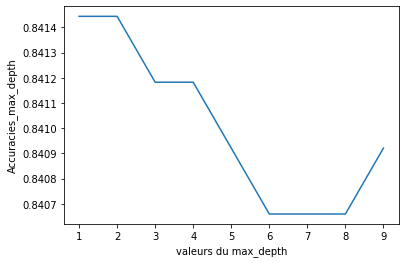

Le meilleur max_depth est : 1


In [339]:
score_max=0
max_depth_opti=1
accuracies_max_depth = []
for i in range(1,10):

    xgboost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,max_depth=i, random_state=0,subsample=0.8).fit(X_train, y_train)
    score=xgboost.score(X_test,y_test)
    accuracies_max_depth.append(score)
    if score>score_max:
        max_depth_opti=i
        score_max=score
    
plt.plot(range(1,10),accuracies_max_depth)
plt.ylabel('Accuracies_max_depth')
plt.xlabel("valeurs du max_depth")
plt.show()
print("Le meilleur max_depth est :", max_depth_opti)

In [340]:
xgboost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,max_depth=max_depth_opti, random_state=0,subsample=0.8).fit(X_train, y_train)
xgboost.score(X_test,y_test)

0.8414442700156985

#### learning_rate

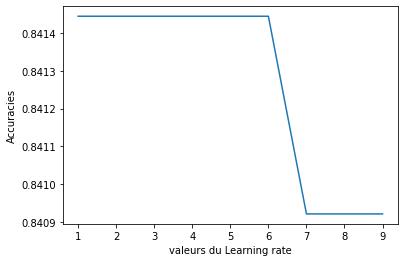

Le meilleur max_depth est : 0.01


In [343]:
score_max=0
learning_rate_opti= 0.001
accuracies_learning_rate = []

for i in range(1,10):
    l = 0.01*i
    xgboost = GradientBoostingClassifier(n_estimators=100, learning_rate=l,max_depth=max_depth_opti, random_state=0,subsample=0.8).fit(X_train, y_train)
    score=xgboost.score(X_test,y_test)
    accuracies_learning_rate.append(score)
    if score>score_max:
        learning_rate_opti=l
        score_max=score
        
plt.plot(range(1,10),accuracies_learning_rate)
plt.ylabel('Accuracies')
plt.xlabel("valeurs du Learning rate")
plt.show()
print("Le meilleur learning_rate est :", learning_rate_opti)

In [344]:
xgboost = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate_opti,max_depth=max_depth_opti, random_state=0,subsample=0.8).fit(X_train, y_train)
xgboost.score(X_test,y_test)

0.8414442700156985

#### n_estimators

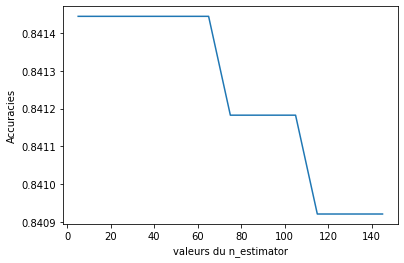

Le meilleur n_estimator est : 5


In [351]:
score_max=0
n_estimators_opti= 0.001
accuracies_n_estimator = []

for i in range(5,150,10):
    xgboost = GradientBoostingClassifier(n_estimators=i, learning_rate=l,max_depth=max_depth_opti, random_state=0,subsample=0.8).fit(X_train, y_train)
    score=xgboost.score(X_test,y_test)
    accuracies_n_estimator.append(score)
    if score>score_max:
        n_estimator_opti=i
        score_max=score
        
plt.plot(range(5,150,10),accuracies_n_estimator)
plt.ylabel('Accuracies')
plt.xlabel("valeurs du n_estimator")
plt.show()
print("Le meilleur n_estimator est :", n_estimator_opti)

In [353]:
xgboost = GradientBoostingClassifier(n_estimators=n_estimator_opti, learning_rate=learning_rate_opti,max_depth=max_depth_opti, random_state=0,subsample=0.8).fit(X_train, y_train)
xgboost.score(X_test,y_test)

0.8414442700156985

On a fini de fine tuner xgboost nous pourrons l'utiliser dans la partie 2.

## III. Application en direct

### III. 1) Application avec une labelisation binaire

In [37]:
%reset -f

In [78]:
import pandas as pd
import numpy as np
from ipywidgets import AppLayout, Button, GridspecLayout, Image, Layout, Text, Box
import random
from sklearn import preprocessing
import sklearn
from sklearn.model_selection import train_test_split
import random
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [79]:
readers = pd.read_csv('vgsales.csv')

On ré-applique le preprocessing.

In [80]:
readers = sklearn.utils.shuffle(readers)

indesirable = ['SAT','2600','NES','GB', 'DC', 'GEN', 'NG', 'SCD', 'WS', '3DO', 'TG16', 'GG', 'PCFX','PSV']
for elt in indesirable:
    readers = readers.drop(readers[readers.Platform == elt].index)
    
readers['Platform'] = readers['Platform'].replace(['DS','Wii','GBA','GC','3DS','N64','SNES','WiiU'], 'Nintendo')
readers['Platform'] = readers['Platform'].replace(['PS2','PS3','PSP','PS','PS4'], 'Sony')
readers['Platform'] = readers['Platform'].replace(['X360','XB','XOne'], 'Microsoft')


readers = readers.drop(columns=["Rank","Other_Sales"])

readers=readers.drop(readers[readers.Global_Sales==82.74].index)

X=readers

X = pd.DataFrame(X).fillna("Unknow")
X["Interest"] = 0



A titre de rapidité, nous allons prendre seulement 2000 jeux de notre base de données car sinon lorsque l'on mettra en route notre application, elle prendra du temps avant de sortir un nouveau jeu. 

Cependant, sur un ordinateur plus puissant il est possible de lancer le code avec la base de données en entier ou sinon il suffit d'être patient ! 

In [81]:
X = X[:2000]

Puis on encode les données

In [82]:
cols = ["Platform", "Genre","Publisher","Name"]
enc = preprocessing.OrdinalEncoder()
X_copy = X.copy()                                                  #On fait une copie pour garder les noms sans encodage pour pouvoir les afficher ensuite
for col in cols:
    X_copy[col] = enc.fit_transform(X_copy[[col]])
    
    
X_copy = X_copy.drop('Interest',axis=1)

In [83]:
def create_button(description, button_style):
    return Button(
        description=description,
        button_style=button_style,
        layout=Layout(height='auto', width='auto')
    )


def ligne_aleat():
    liste_index=X.index.values.tolist()
    index_aleat=random.randint(0,len(liste_index))
    return liste_index[index_aleat]



def get_Name(index, dataset):
    return Text(value= dataset.loc[index].Name+" Genre:"+dataset.loc[index].Genre+" Platform:"+dataset.loc[index].Platform+" Year:"+str(dataset.loc[index].Year) , placeholder='Type something',description='Game:',disabled=False)


In [84]:


# bouton gauche: Not Interested
left_button = create_button('Not Interested', 'danger')

# nom au centre
ligne_aleat_actuel= ligne_aleat()
center = get_Name(ligne_aleat_actuel, X)
Name = get_Name(ligne_aleat_actuel, X)

# bouton droit: Interested
right_button = create_button('Interested', 'success')

cols = ["Platform", "Genre","Publisher","Interest"]

def on_button_clicked(b):

### On met à jour la valeur selon ce que clique l'utilisateur
    update_values(b)
    nb_aleat = choisir_ligne_aleat()                    ##On choisit un nouveau jeu
    update_Name(b, nb_aleat)                            ##On lui met un nouveau nom

    


def update_values(b):
### On met à jour la colonne Interested selon le choix de l'utilisateur

    global ligne_aleat_actuel
    if b.description == "Interested":
        interested = 2 #Interessé
    else: 
        interested = 1 #Pas Interessé
    X.loc[ligne_aleat_actuel, 'Interest'] = interested
    

    

def choisir_ligne_aleat():
    
### Dans cette fonction, on choisit le prochain jeu à proposer de manière aléatoire (1 fois sur 10) pour ne pas converger trop vite 
    random_value = random.uniform(0, 1)                 
    if random_value < 0.1:
        nb_aleat = ligne_aleat()
        if X.loc[nb_aleat].Interest == 0:
            return nb_aleat
    
        while(X.loc[nb_aleat].Interest !=0):
            nb_aleat = ligne_aleat()
        return nb_aleat

  
   
    
### XGBoost   
    y = X['Interest']
    xgboost = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,max_depth=1, random_state=0).fit(X_copy, y)
    #On n'utilise pas ici notre boosting de paramètre car la labélisation était pour celle de préférence


### Si on a encore aucune labélisation

    if (xgboost.predict_proba(X_copy).shape[1] != 3):
        nb_aleat = ligne_aleat()
        if X.loc[nb_aleat].Interest ==0:
            return nb_aleat
        while(X.loc[nb_aleat].Interest != 0):
            nb_aleat = ligne_aleat()
        return nb_aleat
    
    
    
### Ranger par proba
    X['prediction'] = [elt[0] for elt in xgboost.predict_proba(X_copy)[:,2:3].tolist()]
    sorted_ops = X.sort_values(by="prediction", ascending=False)    #on range les jeux du plus probable d'aimer au moins probable
    for i in (sorted_ops.iloc[:,10].index):
        if X.loc[i].Interest ==0:                                   #Si le jeu n'est pas labéliser on retourne celui dont il est le plus susceptible d'aimer
            return i
        


def update_Name(b, nb_aleat):
    
### On met à jour le nom du milieu
    global ligne_aleat_actuel

    ligne_aleat_actuel = nb_aleat
    Name = X.loc[ligne_aleat_actuel].Name+" Genre:"+X.loc[ligne_aleat_actuel].Genre+" Platform:"+X.loc[ligne_aleat_actuel].Platform+" Year:"+str(X.loc[ligne_aleat_actuel].Year)
    center.value = Name


# On met en place l'application du bouton
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

AppLayout(
    left_sidebar=left_button,
    center=center,
    right_sidebar=right_button
)

AppLayout(children=(Button(button_style='danger', description='Not Interested', layout=Layout(grid_area='left-…

On obtient ensuite les jeux qui sont le plus suscpetible d'être aimé par l'utilisateur.

In [85]:
X.sort_values(by = ['prediction'],ascending = False)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Global_Sales,Interest,prediction
1258,The Legend of Zelda: Ocarina of Time,Nintendo,1998,Action,Nintendo,4.10,1.89,1.45,7.60,2,0.822475
15018,Skylanders: Trap Team,Nintendo,2014,Action,Activision,0.14,0.10,0.00,0.26,2,0.424915
13939,Skylanders Giants,Nintendo,2012,Action,Activision,0.12,0.01,0.00,0.14,0,0.424915
13849,Family Guy: Back to the Multiverse,Microsoft,2012,Action,Activision,0.14,0.09,0.00,0.25,2,0.424915
15640,Skylanders: SuperChargers,Nintendo,2015,Action,Activision,0.05,0.06,0.00,0.11,0,0.424915
...,...,...,...,...,...,...,...,...,...,...,...
9772,Friend Collection,Nintendo,2009,Misc,Nintendo,0.00,0.00,3.67,3.67,0,0.000000
3635,Final Fantasy X-2,Sony,2003,Role-Playing,Electronic Arts,1.92,1.08,2.11,5.29,0,0.000000
4459,Dragon Quest V: Tenkuu no Hanayome,Sony,2004,Role-Playing,Enix Corporation,0.00,0.00,1.65,1.65,0,0.000000
1658,Hot Shots Golf 2,Sony,1999,Sports,Sony Computer Entertainment,0.25,0.12,1.48,1.88,0,0.000000


On arrive à plutôt bien prédire les données par exemple si on aime une plateforme ou un genre, on nous propose beaucoup de jeux de ce genre. 

### III. 2) Application avec une labelisation par préférence

Dans cette application, nous allons donc utiliser random forest car c'est le plus performant selon notre première analyse.

In [86]:
%reset -f

In [87]:
import pandas as pd
import numpy as np
from ipywidgets import AppLayout, Button, GridspecLayout, Image, Layout, Text, Box
import random
from sklearn import preprocessing
import sklearn
from sklearn.model_selection import train_test_split
import random
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [88]:
readers = pd.read_csv('vgsales.csv')

On réapplique le pré-processing de la première partie

In [89]:
readers = sklearn.utils.shuffle(readers)

indesirable = ['SAT','2600','NES','GB', 'DC', 'GEN', 'NG', 'SCD', 'WS', '3DO', 'TG16', 'GG', 'PCFX','PSV']
for elt in indesirable:
    readers = readers.drop(readers[readers.Platform == elt].index)
    
readers['Platform'] = readers['Platform'].replace(['DS','Wii','GBA','GC','3DS','N64','SNES','WiiU'], 'Nintendo')
readers['Platform'] = readers['Platform'].replace(['PS2','PS3','PSP','PS','PS4'], 'Sony')
readers['Platform'] = readers['Platform'].replace(['X360','XB','XOne'], 'Microsoft')


readers = readers.drop(columns=["Rank","Other_Sales"])

readers=readers.drop(readers[readers.Global_Sales==82.74].index)

X=readers
X = pd.DataFrame(X).fillna("Unknow")
X["est_labelise"]=0
X["Interest"] = 1


A titre de rapidité, nous allons prendre seulement 2000 jeux de notre base de données car sinon lorsque l'on mettra en route notre application, elle prendra du temps avant de sortir un nouveau jeu. 

Cependant, sur un ordinateur plus puissant il est possible de lancer le code avec la base de données en entier ou sinon il suffit d'être patient ! 

In [90]:
X = X[:2000]

(On ne va donc pas pouvoir utiliser les hyperparamètres boostés précédemment car nous avons tronqué notre base de données, dans une mise en production, nous aurions pris les hyper paramètres plus haut)

Puis, on re labélise les données comme dans la première partie du projet de 1 à 5 selon la localisation de l'acheteur.

In [91]:
# Ici on traite les ventes dans le monde


seuil_Global_Sales_75= int(0.25*len(X['Global_Sales'].sort_values()))             #nombre de jeux qui font parti des 25% des jeux les moins vendus       
liste_Global_Sales_75= X['Global_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
liste_Global_Sales_75=liste_Global_Sales_75.tolist()


for i in range(seuil_Global_Sales_75):
    liste_Global_Sales_75.pop(0)

#A la fin on obtient une liste des 75% des jeux les plus vendus dans le monde


seuil_Global_Sales_40= int(0.6*len(X['Global_Sales'].sort_values()))             #nombre de jeux qui qui font parti des 60% les moins vendus       
liste_Global_Sales_40= X['Global_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
liste_Global_Sales_40=liste_Global_Sales_40.tolist()


for i in range(seuil_Global_Sales_40):
    liste_Global_Sales_40.pop(0)
    
#A la fin on obtient une liste des 40% des jeux les plus vendus dans le monde

In [92]:
# Ici on traite les ventes dans la région de l'acheteur

def traitementpays(pays):

#L'acheteur vient d'Amérique du Nord
    if pays==0:                                                                   
        seuil_region_Sales_75= int(0.25*len(X['NA_Sales'].sort_values()))             #nombre de jeux qui font parti des 25% des jeux les moins vendus       
        liste_region_Sales_75= X['NA_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
        liste_region_Sales_75=liste_region_Sales_75.tolist()


        for i in range(seuil_region_Sales_75):
            liste_region_Sales_75.pop(0)

#A la fin on obtient une liste des 75% des jeux les plus vendus en Amérique du Nord


        seuil_region_Sales_15= int(0.85*len(X['NA_Sales'].sort_values()))             #nombre de jeux qui qui font parti des 85% les moins vendus       
        liste_region_Sales_15= X['NA_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
        liste_region_Sales_15=liste_region_Sales_15.tolist()


        for i in range(seuil_region_Sales_15):
            liste_region_Sales_15.pop(0)
    
#A la fin on obtient une liste des 15% des jeux les plus vendus en Amérique du Nord






#L'acheteur vient d'Europe
    elif pays==1:
        seuil_region_Sales_75= int(0.25*len(X['EU_Sales'].sort_values()))             #nombre de jeux qui font parti des 25% des jeux les moins vendus       
        liste_region_Sales_75= X['EU_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
        liste_region_Sales_75=liste_region_Sales_75.tolist()


        for i in range(seuil_region_Sales_75):
            liste_region_Sales_75.pop(0)

#A la fin on obtient une liste des 75% des jeux les plus vendus en Europe


        seuil_region_Sales_15= int(0.85*len(X['EU_Sales'].sort_values()))             #nombre de jeux qui qui font parti des 85% les moins vendus       
        liste_region_Sales_15= X['EU_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
        liste_region_Sales_15=liste_region_Sales_15.tolist()


        for i in range(seuil_region_Sales_15):
            liste_region_Sales_15.pop(0)
    
#A la fin on obtient une liste des 15% des jeux les plus vendus en Europe





#L'acheteur vient du Japon
    else : 
        seuil_region_Sales_75= int(0.25*len(X['JP_Sales'].sort_values()))             #nombre de jeux qui font parti des 25% des jeux les moins vendus       
        liste_region_Sales_75= X['JP_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
        liste_region_Sales_75=liste_region_Sales_75.tolist()


        for i in range(seuil_region_Sales_75):
            liste_region_Sales_75.pop(0)

#A la fin on obtient une liste des 75% des jeux les plus vendus au Japon


        seuil_region_Sales_15= int(0.85*len(X['JP_Sales'].sort_values()))             #nombre de jeux qui qui font parti des 85% les moins vendus       
        liste_region_Sales_15= X['JP_Sales'].sort_values()                            #on trie les jeux par ordre croissant de vente
        liste_region_Sales_15=liste_region_Sales_15.tolist()


        for i in range(seuil_region_Sales_15):
            liste_region_Sales_15.pop(0)
    
#A la fin on obtient une liste des 15% des jeux les plus vendus au Japon

    for elt in X.iterrows():
        X.loc[elt[0], 'Interest'] = 1                                ##On met le jeu par défaut à 1
    
    #Si l'acheteur vient d'Amérique
        if pays==0:
            if X.loc[elt[0]].NA_Sales in liste_region_Sales_75 :      ##Le jeu est dans les 75% les plus vendus en Amérique du Nord, on le met à neutre 3
                X.loc[elt[0], 'Interest'] = 3
            
            if X.loc[elt[0]].NA_Sales in liste_region_Sales_15 :      ##Le jeu est dans les 15% les plus vendus en Amérique du Nord, on le met à plutôt interessé 4
                X.loc[elt[0], 'Interest'] = 4
            
    #Si l'acheteur vient d'Europe
        elif pays==1:
            if X.loc[elt[0]].EU_Sales in liste_region_Sales_75 :      ##Le jeu est dans les 75% les plus vendus en Europe, on le met à neutre 3
                X.loc[elt[0], 'Interest'] = 3
            
            if X.loc[elt[0]].EU_Sales in liste_region_Sales_15 :      ##Le jeu est dans les 15% les plus vendus en Europe, on le met à plutôt interessé 4
                X.loc[elt[0], 'Interest'] = 4
            
    #Si l'acheteur vient du Japon
        else :
            if X.loc[elt[0]].JP_Sales in liste_region_Sales_75 :      ##Le jeu est dans les 75% les plus vendus au Japon, on le met à neutre 3
                X.loc[elt[0], 'Interest'] = 3
            
            if X.loc[elt[0]].JP_Sales in liste_region_Sales_15 :      ##Le jeu est dans les 15% les plus vendus au Japon, on le met à plutôt interessé 4
                X.loc[elt[0], 'Interest'] = 4

            
            
        if X.loc[elt[0], 'Interest'] < 3 :                              #Si on est pas déjà au moins à neutre
            if X.loc[elt[0]].Global_Sales in liste_Global_Sales_75 :      ##Le jeu est dans les 75% les plus vendus dans le monde, on le met à plutôt pas interessé
                X.loc[elt[0], 'Interest'] = 2
    
            if X.loc[elt[0]].Global_Sales in liste_Global_Sales_40 :      ##Le jeu est dans les 40% les plus vendus dans le monde, on le met à neutre.
                X.loc[elt[0], 'Interest'] = 3
    

In [93]:
L=[0,1,2]
pays=3
while pays not in L:
    print("De quelle région venez-vous ?\n 0 : Amérique du Nord\n 1 : Europe\n 2 : Japon")
    pays = int(input())
    

traitementpays(pays)      ##on fait un pré-traitement des données par région

De quelle région venez-vous ?
 0 : Amérique du Nord
 1 : Europe
 2 : Japon
1


On va ensuite labeliser les données comme on nous avons pu voir précédemment en utilisant les préférences. 

In [94]:
### ENCODING ####        
cols = ["Platform", "Genre","Publisher","Name"]
enc = preprocessing.OrdinalEncoder()
X_copy = X.copy()                                                  #On fait une copie pour garder les noms sans encodage pour pouvoir les afficher ensuite
for col in cols:
    X_copy[col] = enc.fit_transform(X_copy[[col]])
    
    
X_copy = X_copy.drop('Interest',axis=1)

In [95]:
def create_button(description, button_style):
    return Button(
        description=description,
        button_style=button_style,
        layout=Layout(height='auto', width='auto')
    )


def ligne_aleat():
    liste_index=X.index.values.tolist()
    index_aleat=random.randint(0,len(liste_index))
    return liste_index[index_aleat]



def get_Name(index, dataset):
    return Text(value= dataset.loc[index].Name+" Genre:"+dataset.loc[index].Genre+" Platform:"+dataset.loc[index].Platform+" Year:"+str(dataset.loc[index].Year) , placeholder='Type something',description='Game:',disabled=False)


In [96]:
# bouton gauche: Not Interested
left_button =  create_button('Not Interested', 'danger')

# nom au centre
ligne_aleat_actuel = ligne_aleat()
center = get_Name(ligne_aleat_actuel, X)
Name = get_Name(ligne_aleat_actuel, X)

# bouton droit: Interested
right_button =  create_button('Interested', 'success')

cols = ["Platform", "Genre","Publisher","Interest"]

def on_button_clicked(b):

# On met à jour les valeurs selon le choix de l'utilisateur
    update_values(b)
    nb_aleat = choisir_ligne_aleat()
    update_Name(b, nb_aleat)

    

def update_values(b):
## On met à jour la colonne 'interested'

    global ligne_aleat_actuel
    if b.description == "Interested":
        X.loc[ligne_aleat_actuel, 'Interest'] +=1   #Interessé  
    else: 
        X.loc[ligne_aleat_actuel, 'Interest'] = 1   #Pas Interessé
    X.loc[ligne_aleat_actuel, 'est_labelise'] = 1

    

def choisir_ligne_aleat():
    
### Dans cette fonction, on choisit le prochain jeu à proposer de manière aléatoire (1 fois sur 10)
    random_value = random.uniform(0, 1)                 
    if random_value < 0.1:
        nb_aleat = ligne_aleat()
        if X.loc[nb_aleat].est_labelise == 0:
            return nb_aleat
    
        while(X.loc[nb_aleat].est_labelise !=0):
            nb_aleat = ligne_aleat()
        return nb_aleat

    
### XGBoost  ### 
    y = X['Interest']
    xgboost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,max_depth=1, random_state=0).fit(X_copy, y)
    
    
### Ranger par proba
                           #moyenne entre les deux dernieres valeurs de predict proba pour chaque jeu 
    taille=xgboost.predict_proba(X_copy).shape[1]
    l=xgboost.predict_proba(X_copy)[:,taille-2:taille].tolist()
    liste=[]
    for i in range(len(l)):
        somme=l[i][0]+l[i][1]
        liste.append(somme)
    X['prediction'] = liste
    
    sorted_ops = X.sort_values(by="prediction", ascending=False)
    for i in (sorted_ops.iloc[:,11].index):
        if X.loc[i].est_labelise ==0:
            return i


def update_Name(b, nb_aleat):
#on renouvelle le nom au centre de l'application
    global ligne_aleat_actuel

    ligne_aleat_actuel = nb_aleat
    Name = X.loc[ligne_aleat_actuel].Name+" Genre:"+X.loc[ligne_aleat_actuel].Genre+" Platform:"+X.loc[ligne_aleat_actuel].Platform+" Year:"+str(X.loc[ligne_aleat_actuel].Year)
    center.value = Name
    

# Set the on_click function to the button
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

AppLayout(
    left_sidebar=left_button,
    center=center,
    right_sidebar=right_button
)

AppLayout(children=(Button(button_style='danger', description='Not Interested', layout=Layout(grid_area='left-…

On va afficher notre base de données par ordre de prédiction selon notre modèle.

In [68]:
X.sort_values(by="prediction", ascending=False)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Global_Sales,est_labelise,Interest,prediction
6611,Digimon World DS,Nintendo,2006,Role-Playing,Namco Bandai Games,0.10,0.00,0.00,0.11,0,3,0.999858
5074,Trigger Man,Microsoft,2004,Shooter,Crave Entertainment,0.03,0.01,0.00,0.05,0,3,0.999858
6489,Phantasy Star Universe,Sony,2006,Role-Playing,Sega,0.00,0.00,0.19,0.19,0,3,0.999858
12415,King of Fighters 2002: Unlimited Match Tougeki...,Sony,2010,Fighting,SNK Playmore,0.00,0.00,0.01,0.01,0,3,0.999858
6559,Master Jin Jin's IQ Challenge,Nintendo,2006,Misc,505 Games,0.13,0.00,0.00,0.14,0,3,0.999858
...,...,...,...,...,...,...,...,...,...,...,...,...
742,Pilotwings 64,Nintendo,1996,Simulation,Nintendo,0.56,0.24,0.30,1.12,0,4,0.997378
3672,DDRMAX2: Dance Dance Revolution,Sony,2003,Simulation,Konami Digital Entertainment,1.05,0.59,0.00,1.81,0,4,0.997378
1047,NBA ShootOut '97,Sony,1997,Sports,Sony Computer Entertainment,0.35,0.24,0.00,0.62,0,4,0.997378
2384,NCAA Football 2002,Sony,2001,Sports,Electronic Arts,0.77,0.60,0.00,1.57,0,4,0.997378


Dans notre simulation on a aimé un grand nombre de jeu d'action et on remarque qu'en haut de la liste les jeux sont tous d'action donc notre algorithme a bien convergé.

## Conclusion

Notre projet a ainsi abouti a une application qui fonctionne. Cependant, un acheteur reste irrationnel et peut parfois aimer ou non des jeux sans explication, c'est pourquoi il est parfois difficile de faire un système de recommendation. 


Nous avons choisi comme modèle xgboost mais il serait intéressant d'enregistrer les scores selon le bot etc ce qui est compliqué sur un notebook car on réinitialise au début de chaque lancement.

Pour une mise en production sur un site de vente de jeux une amélioration possible serait d'aggréger les préférences selon le temps passé à regarder un jeu, analyser ses habitudes etc.